In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import urllib.request
import time
import os, shutil
import cv2
from os import listdir
from os.path import isfile, join
from PIL import Image
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.layers.core import Flatten, Dense, Dropout

In [6]:
raw = pd.read_csv('dress_patterns.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 4 columns):
_unit_id               15702 non-null int64
category               15702 non-null object
category:confidence    15702 non-null float64
image_url              15702 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 490.8+ KB


In [7]:
raw.describe(include='all')

,_unit_id,category,category:confidence,image_url
count,1.570200e+04,15702,15702.000000,15702
unique,NaN,17,NaN,15548
top,NaN,plain,NaN,http://s3-eu-west-1.amazonaws.com/we-attribute...
freq,NaN,8385,NaN,3
mean,8.515145e+08,NaN,0.856637,NaN
std,6.166987e+04,NaN,0.216946,NaN
min,8.515055e+08,NaN,0.253800,NaN
25%,8.515094e+08,NaN,0.674500,NaN
50%,8.515134e+08,NaN,1.000000,NaN
75%,8.515175e+08,NaN,1.000000,NaN


In [8]:
raw.category.value_counts()

plain          8385
floral         2776
stripes         701
polka dot       651
OTHER           513
tribal          507
squares         439
ikat            355
animal          352
geometry        342
cartoon         261
scales          112
chevron          96
letter_numb      82
houndstooth      66
stars            45
skull            19
Name: category, dtype: int64

There are 17 fabric pattern categories and most of the images are either plain or floral pattern. There is also a confidence value for whether the image of the link is correctly labeled. There are 15,508 unique image links and over 150 duplicated links. 

## Image Retrieval

Since that there are many categories with less than 400 images, the plan is to narrow down the categories to trained and evaluated in CNN. The images with a confidence value of 1 from top 5 most frequent categories will be downloaded to the correct category-labeled folders

In [9]:
raw_confident_1 = raw[raw['category:confidence']==1]

In [10]:
raw_confident_1 = raw_confident_1.drop_duplicates(subset='image_url')
raw_confident_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10271 entries, 1 to 15631
Data columns (total 4 columns):
_unit_id               10271 non-null int64
category               10271 non-null object
category:confidence    10271 non-null float64
image_url              10271 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 401.2+ KB


In [11]:
raw_confident_1.category.value_counts()

plain          6687
floral         1861
stripes         498
polka dot       363
squares         267
animal          190
tribal          109
cartoon          52
letter_numb      51
geometry         41
ikat             40
OTHER            34
chevron          27
houndstooth      15
stars            15
scales           11
skull            10
Name: category, dtype: int64

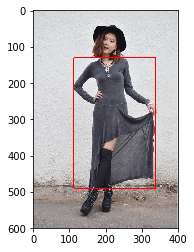

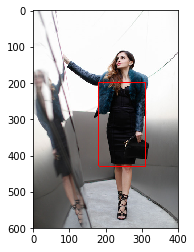

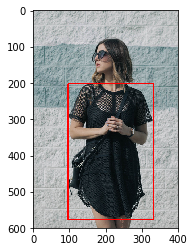

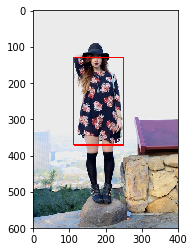

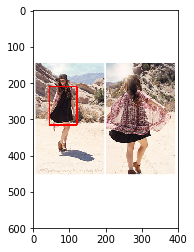

In [14]:
# show 5 pictures from the image_url.
img_urls = raw_confident_1.image_url[1:6]

for idx, img_url in enumerate(img_urls, start=1):
    img = Image.open(urllib.request.urlopen(img_url))
    plt.figure(idx)
    imgplot = plt.imshow(img)
    plt.show()

All these photos show that the dresses are modeled by ladies in natural backdrop. In a few of the pictures, jacket and accessories are also featured. This creates additional noise which the cnn model needs to be able to filter out in order to identify correctly.There is a bounding box in every picture which could be used to isolate the noise.

In [15]:
# create separate dataframes for each of the 5 categories
plain_imgs = raw_confident_1[raw_confident_1['category']=='plain']
floral_imgs = raw_confident_1[raw_confident_1['category']=='floral']
stripes_imgs = raw_confident_1[raw_confident_1['category']=='stripes']
polkadot_imgs = raw_confident_1[raw_confident_1['category']=='polka dot']
squares_imgs = raw_confident_1[raw_confident_1['category']=='squares']

plain_imgs.reset_index(inplace=True, drop=True)
floral_imgs.reset_index(inplace=True, drop=True)
stripes_imgs.reset_index(inplace=True, drop=True)
polkadot_imgs.reset_index(inplace=True, drop=True)
squares_imgs.reset_index(inplace=True, drop=True)

In [30]:
# variables required to create train, validation and test folders and for downloading images to the correct folders
imglists = [plain_imgs, floral_imgs, stripes_imgs, polkadot_imgs, squares_imgs]
catlist = patterns[:5]
m_folders = ['{}_folder'.format(method) for method in ['train', 'test', 'val']]
p_folders = ['{}_{}'.format(method, pattern) for method in ['train', 'test', 'val'] for pattern in ['plain', 'floral', 'stripes', 'polkadot', 'squares']]
patterns = ['plain', 'floral', 'stripes', 'polkadot', 'squares']*3

In [26]:
# creating 2 directories one for original and the other for cropped images
directories = ['split/', 'split2/']
for new_dir in directories:
    os.mkdir(new_dir)
    
    # creating train, validation and test folders where 5 other folders of fabric patterns can be found
    for m_folder, label in zip(m_folders, ['train', 'test', 'validation']):
        m_folder = os.path.join(new_dir, label)
        os.mkdir(m_folder)

        for p_folder, label in zip(p_folders, patterns):
            if 'train' in p_folder and 'train' in m_folder:
                p_folder = os.path.join(m_folder, label)
                os.mkdir(p_folder)
            elif 'test' in p_folder and 'test' in m_folder:
                p_folder = os.path.join(m_folder, label)
                os.mkdir(p_folder)
            elif 'val' in p_folder and 'val' in m_folder:
                p_folder = os.path.join(m_folder, label)
                os.mkdir(p_folder)

In [58]:
def get_imgs(category_dataframe, category_name):
    
    """
    retrieves images from image_url and save an original and a cropped image to the correct location
    """
    
    if len(category_dataframe) > 390:
        category_dataframe = category_dataframe[:390]
        
    count=0
    for url in category_dataframe['image_url']:
        count+=1
        if count%50 == 0:
            time.sleep(5)
        
        if count <= 50:
            with open('split/test/{0}/{0}{1}.png'.format(category_name, count), 'wb') as handle:
                write_img(url, handle)
                
            source = 'split/test/{0}/{0}{1}.png'.format(category_name, count)
            destination = 'split2/test/{0}/cropped_{0}{1}.png'.format(category_name, count)
            if isfile(source):
                crop_img(source, destination)
            else:
                print('Unable to crop image for: '+source)
                
        elif count > 50 and count <= 90:
            with open('split/validation/{0}/{0}{1}.png'.format(category_name, count-50), 'wb') as handle:
                write_img(url, handle)
                
            source = 'split/validation/{0}/{0}{1}.png'.format(category_name, count-50)
            destination = 'split2/validation/{0}/cropped_{0}{1}.png'.format(category_name, count-50)
            if isfile(source):
                crop_img(source, destination)
            else:
                print('Unable to crop image for: '+source)
        else:
            with open('split/train/{0}/{0}{1}.png'.format(category_name, count-90), 'wb') as handle:
                write_img(url, handle)
                
            source = 'split/train/{0}/{0}{1}.png'.format(category_name, count-90)
            destination = 'split2/train/{0}/cropped_{0}{1}.png'.format(category_name, count-90)
            if isfile(source):
                crop_img(source, destination)
            else:
                print('Unable to crop image for: '+source)
                    
def write_img(url, handle):
    
    """
    saves the original image
    """
    
    response = requests.get(url, stream=True)

    if not response.ok:
        print(response)
    else:
        for block in response.iter_content(1024):
            if not block:
                break
            else:
                handle.write(block)
        
def crop_img(source, destination):
    
    """
    crops the image around the bounding box and save the image
    """

    img = cv2.cvtColor(cv2.imread(source), cv2.COLOR_BGR2RGB)
    coordinates = []

    for y_coordinate, row in enumerate(img):
        for x_coordinate, pixel in enumerate(row):
            #find the ones that are ONLY red
            if pixel.tolist() == [255,0,0]:
                coordinates.append([x_coordinate,y_coordinate])

    if coordinates == []:
        print(source)
        pass

    else:

        p1 = min(coordinates)[0]
        p2 = min(coordinates)[1]
        p3 = max(coordinates)[0]
        p4 = max(coordinates)[1]

        image = Image.open(source)
        box = (p1, p2, p3, p4)
        try:
            cropped_image = image.crop(box)
        except: 
            print(source)
            pass
        cropped_image.save(destination)


split/train/polkadot/polkadot270.png

In [35]:
for imglist, cat in zip(imglists, catlist):
    get_imgs(imglist, cat)

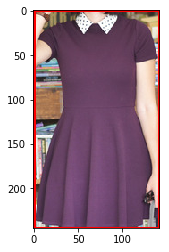

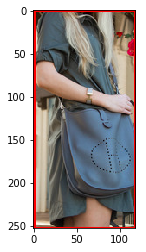

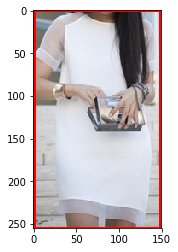

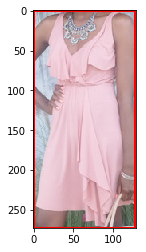

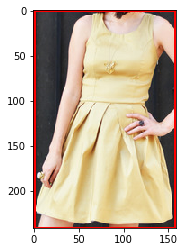

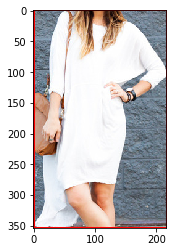

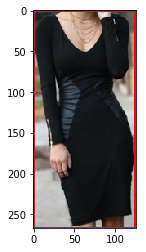

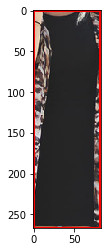

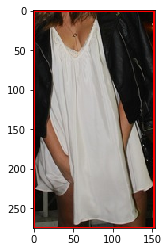

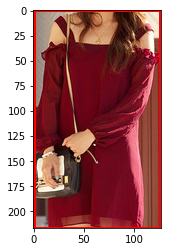

In [4]:
# checking out cropped plain dress images from test folder
test_plain_imgs = []
test_plain_files = [f for f in listdir('split2/test/plain/') if isfile(join('split2/test/plain/', f))]
for item in test_plain_files:
    test_plain_imgs.append('split2/test/plain/'+item)
test_plain_imgs = test_plain_imgs[:10]   

for idx, img_url in enumerate(test_plain_imgs):
    img = Image.open(img_url)
    plt.figure(idx)
    imgplot = plt.imshow(img)
    plt.show()

#### To continue, kindly open CNN Model Building.ipynb to view the rest of the code. Please note that the codes in that notebook are written to run on Google Colab with the two folders of images(split and split2) already saved on your Google Drive. Thank you.